### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e0d3624f-a6a7-58ad-5dea-bc7a5e04e915)


In [ ]:
%%capture
!pip install transformers # for CLIPTokenizer
!pip install diffusers
# !pip install daam # for Heatmap generation
!pip install accelerate  # this is to reduce CPU model load overhead
!pip install ftfy regex tqdm
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

### Load Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [ ]:
# General
import os
import json
import datetime
from tqdm import tqdm
import base64
import IPython
import random
import requests
from io import BytesIO
from math import trunc

# Plotting
from matplotlib import pyplot as plt

# Data Handling
import numpy as np
from pycocotools.coco import COCO

# Image Processing
from PIL import Image
from PIL import ImageDraw as PILImageDraw
import cv2

# Image Generation
# from diffusers import StableDiffusionImg2ImgPipeline - I have added the modified function below
# import daam

# Model
import torch

### Load Data

The below list is a placeholder for any list of prompts, we will be replacing it with a list of prompts from `MS-COCO` text annotations later.

['Pasta']


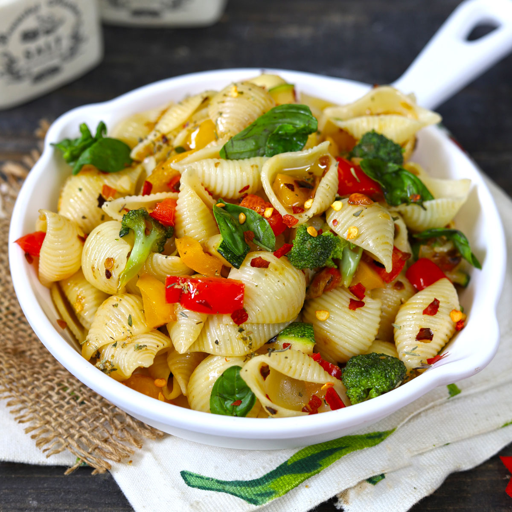

In [ ]:
# Objects to detect in the image separated by spaces
prompts = [
  "Pasta"
]
print(prompts)

# Image
url = "https://www.funfoodfrolic.com/wp-content/uploads/2021/01/Stir-Fry-Pasta-Thumbnail.jpg"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
# init_img = Image.open('img.png').convert("RGB")
init_img = init_img.resize((512, 512))
init_img

### Experimenting Cross-Image Diffusion

#### Set some parameters

In [ ]:
DEVICE = 'cuda' # device
DIFFUSION_MODEL_PATH = 'stabilityai/stable-diffusion-2-base' # Set the model path to load the diffusion model from

For visualizing purposes, I needed to change the source code a bit for adding the lines for visualizing the `latents` in `UNet` Denoising.

In [ ]:
# For visualizing - I change the source code a bit

# Copyright 2022 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import inspect
from typing import Callable, List, Optional, Union

import numpy as np
import torch

import PIL
from diffusers.utils import is_accelerate_available
from packaging import version
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from diffusers.configuration_utils import FrozenDict
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import (
    DDIMScheduler,
    DPMSolverMultistepScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    LMSDiscreteScheduler,
    PNDMScheduler,
)
from diffusers.utils import PIL_INTERPOLATION, deprecate, logging
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker


logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL_INTERPOLATION["lanczos"])
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0


class StableDiffusionImg2ImgPipeline(DiffusionPipeline):
    r"""
    Pipeline for text-guided image to image generation using Stable Diffusion.

    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods the
    library implements for all the pipelines (such as downloading or saving, running on a particular device, etc.)

    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`CLIPTextModel`]):
            Frozen text-encoder. Stable Diffusion uses the text portion of
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
            the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        unet ([`UNet2DConditionModel`]): Conditional U-Net architecture to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latents. Can be one of
            [`DDIMScheduler`], [`LMSDiscreteScheduler`], or [`PNDMScheduler`].
        safety_checker ([`StableDiffusionSafetyChecker`]):
            Classification module that estimates whether generated images could be considered offensive or harmful.
            Please, refer to the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5) for details.
        feature_extractor ([`CLIPFeatureExtractor`]):
            Model that extracts features from generated images to be used as inputs for the `safety_checker`.
    """
    _optional_components = ["safety_checker", "feature_extractor"]

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.__init__
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[
            DDIMScheduler,
            PNDMScheduler,
            LMSDiscreteScheduler,
            EulerDiscreteScheduler,
            EulerAncestralDiscreteScheduler,
            DPMSolverMultistepScheduler,
        ],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
        requires_safety_checker: bool = True,
    ):
        super().__init__()

        if hasattr(scheduler.config, "steps_offset") and scheduler.config.steps_offset != 1:
            deprecation_message = (
                f"The configuration file of this scheduler: {scheduler} is outdated. `steps_offset`"
                f" should be set to 1 instead of {scheduler.config.steps_offset}. Please make sure "
                "to update the config accordingly as leaving `steps_offset` might led to incorrect results"
                " in future versions. If you have downloaded this checkpoint from the Hugging Face Hub,"
                " it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json`"
                " file"
            )
            deprecate("steps_offset!=1", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(scheduler.config)
            new_config["steps_offset"] = 1
            scheduler._internal_dict = FrozenDict(new_config)

        if hasattr(scheduler.config, "clip_sample") and scheduler.config.clip_sample is True:
            deprecation_message = (
                f"The configuration file of this scheduler: {scheduler} has not set the configuration `clip_sample`."
                " `clip_sample` should be set to False in the configuration file. Please make sure to update the"
                " config accordingly as not setting `clip_sample` in the config might lead to incorrect results in"
                " future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very"
                " nice if you could open a Pull request for the `scheduler/scheduler_config.json` file"
            )
            deprecate("clip_sample not set", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(scheduler.config)
            new_config["clip_sample"] = False
            scheduler._internal_dict = FrozenDict(new_config)

        if safety_checker is None and requires_safety_checker:
            logger.warning(
                f"You have disabled the safety checker for {self.__class__} by passing `safety_checker=None`. Ensure"
                " that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered"
                " results in services or applications open to the public. Both the diffusers team and Hugging Face"
                " strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling"
                " it only for use-cases that involve analyzing network behavior or auditing its results. For more"
                " information, please have a look at https://github.com/huggingface/diffusers/pull/254 ."
            )

        if safety_checker is not None and feature_extractor is None:
            raise ValueError(
                "Make sure to define a feature extractor when loading {self.__class__} if you want to use the safety"
                " checker. If you do not want to use the safety checker, you can pass `'safety_checker=None'` instead."
            )

        is_unet_version_less_0_9_0 = hasattr(unet.config, "_diffusers_version") and version.parse(
            version.parse(unet.config._diffusers_version).base_version
        ) < version.parse("0.9.0.dev0")
        is_unet_sample_size_less_64 = hasattr(unet.config, "sample_size") and unet.config.sample_size < 64
        if is_unet_version_less_0_9_0 and is_unet_sample_size_less_64:
            deprecation_message = (
                "The configuration file of the unet has set the default `sample_size` to smaller than"
                " 64 which seems highly unlikely .If you're checkpoint is a fine-tuned version of any of the"
                " following: \n- CompVis/stable-diffusion-v1-4 \n- CompVis/stable-diffusion-v1-3 \n-"
                " CompVis/stable-diffusion-v1-2 \n- CompVis/stable-diffusion-v1-1 \n- runwayml/stable-diffusion-v1-5"
                " \n- runwayml/stable-diffusion-inpainting \n you should change 'sample_size' to 64 in the"
                " configuration file. Please make sure to update the config accordingly as leaving `sample_size=32`"
                " in the config might lead to incorrect results in future versions. If you have downloaded this"
                " checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for"
                " the `unet/config.json` file"
            )
            deprecate("sample_size<64", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(unet.config)
            new_config["sample_size"] = 64
            unet._internal_dict = FrozenDict(new_config)

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.register_to_config(requires_safety_checker=requires_safety_checker)

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.enable_attention_slicing
    def enable_attention_slicing(self, slice_size: Optional[Union[str, int]] = "auto"):
        r"""
        Enable sliced attention computation.

        When this option is enabled, the attention module will split the input tensor in slices, to compute attention
        in several steps. This is useful to save some memory in exchange for a small speed decrease.

        Args:
            slice_size (`str` or `int`, *optional*, defaults to `"auto"`):
                When `"auto"`, halves the input to the attention heads, so attention will be computed in two steps. If
                a number is provided, uses as many slices as `attention_head_dim // slice_size`. In this case,
                `attention_head_dim` must be a multiple of `slice_size`.
        """
        if slice_size == "auto":
            if isinstance(self.unet.config.attention_head_dim, int):
                # half the attention head size is usually a good trade-off between
                # speed and memory
                slice_size = self.unet.config.attention_head_dim // 2
            else:
                # if `attention_head_dim` is a list, take the smallest head size
                slice_size = min(self.unet.config.attention_head_dim)

        self.unet.set_attention_slice(slice_size)

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.disable_attention_slicing
    def disable_attention_slicing(self):
        r"""
        Disable sliced attention computation. If `enable_attention_slicing` was previously invoked, this method will go
        back to computing attention in one step.
        """
        # set slice_size = `None` to disable `attention slicing`
        self.enable_attention_slicing(None)

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.enable_sequential_cpu_offload
    def enable_sequential_cpu_offload(self, gpu_id=0):
        r"""
        Offloads all models to CPU using accelerate, significantly reducing memory usage. When called, unet,
        text_encoder, vae and safety checker have their state dicts saved to CPU and then are moved to a
        `torch.device('meta') and loaded to GPU only when their specific submodule has its `forward` method called.
        """
        if is_accelerate_available():
            from accelerate import cpu_offload
        else:
            raise ImportError("Please install accelerate via `pip install accelerate`")

        device = torch.device(f"cuda:{gpu_id}")

        for cpu_offloaded_model in [self.unet, self.text_encoder, self.vae]:
            if cpu_offloaded_model is not None:
                cpu_offload(cpu_offloaded_model, device)

        if self.safety_checker is not None:
            # TODO(Patrick) - there is currently a bug with cpu offload of nn.Parameter in accelerate
            # fix by only offloading self.safety_checker for now
            cpu_offload(self.safety_checker.vision_model, device)

    @property
    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline._execution_device
    def _execution_device(self):
        r"""
        Returns the device on which the pipeline's models will be executed. After calling
        `pipeline.enable_sequential_cpu_offload()` the execution device can only be inferred from Accelerate's module
        hooks.
        """
        if self.device != torch.device("meta") or not hasattr(self.unet, "_hf_hook"):
            return self.device
        for module in self.unet.modules():
            if (
                hasattr(module, "_hf_hook")
                and hasattr(module._hf_hook, "execution_device")
                and module._hf_hook.execution_device is not None
            ):
                return torch.device(module._hf_hook.execution_device)
        return self.device

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.enable_xformers_memory_efficient_attention
    def enable_xformers_memory_efficient_attention(self):
        r"""
        Enable memory efficient attention as implemented in xformers.

        When this option is enabled, you should observe lower GPU memory usage and a potential speed up at inference
        time. Speed up at training time is not guaranteed.

        Warning: When Memory Efficient Attention and Sliced attention are both enabled, the Memory Efficient Attention
        is used.
        """
        self.unet.set_use_memory_efficient_attention_xformers(True)

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.disable_xformers_memory_efficient_attention
    def disable_xformers_memory_efficient_attention(self):
        r"""
        Disable memory efficient attention as implemented in xformers.
        """
        self.unet.set_use_memory_efficient_attention_xformers(False)

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline._encode_prompt
    def _encode_prompt(self, prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
            prompt (`str` or `list(int)`):
                prompt to be encoded
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        untruncated_ids = self.tokenizer(prompt, padding="max_length", return_tensors="pt").input_ids

        if not torch.equal(text_input_ids, untruncated_ids):
            removed_text = self.tokenizer.batch_decode(untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1])
            logger.warning(
                "The following part of your input was truncated because CLIP can only handle sequences up to"
                f" {self.tokenizer.model_max_length} tokens: {removed_text}"
            )

        if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
            attention_mask = text_inputs.attention_mask.to(device)
        else:
            attention_mask = None

        text_embeddings = self.text_encoder(
            text_input_ids.to(device),
            attention_mask=attention_mask,
        )
        text_embeddings = text_embeddings[0]

        # duplicate text embeddings for each generation per prompt, using mps friendly method
        bs_embed, seq_len, _ = text_embeddings.shape
        text_embeddings = text_embeddings.repeat(1, num_images_per_prompt, 1)
        text_embeddings = text_embeddings.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            max_length = text_input_ids.shape[-1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )

            if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
                attention_mask = uncond_input.attention_mask.to(device)
            else:
                attention_mask = None

            uncond_embeddings = self.text_encoder(
                uncond_input.input_ids.to(device),
                attention_mask=attention_mask,
            )
            uncond_embeddings = uncond_embeddings[0]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = uncond_embeddings.repeat(1, num_images_per_prompt, 1)
            uncond_embeddings = uncond_embeddings.view(batch_size * num_images_per_prompt, seq_len, -1)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        return text_embeddings

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.run_safety_checker
    def run_safety_checker(self, image, device, dtype):
        if self.safety_checker is not None:
            safety_checker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(device)
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values.to(dtype)
            )
        else:
            has_nsfw_concept = None
        return image, has_nsfw_concept

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.decode_latents
    def decode_latents(self, latents):
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        return image

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_extra_step_kwargs
    def prepare_extra_step_kwargs(self, generator, eta):
        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]

        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(inspect.signature(self.scheduler.step).parameters.keys())
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

    def check_inputs(self, prompt, strength, callback_steps):
        if not isinstance(prompt, str) and not isinstance(prompt, list):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if strength < 0 or strength > 1:
            raise ValueError(f"The value of strength should in [1.0, 1.0] but is {strength}")

        if (callback_steps is None) or (
            callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

    def get_timesteps(self, num_inference_steps, strength, device):
        # get the original timestep using init_timestep
        offset = self.scheduler.config.get("steps_offset", 0)
        init_timestep = int(num_inference_steps * strength) + offset
        init_timestep = min(init_timestep, num_inference_steps)

        t_start = max(num_inference_steps - init_timestep + offset, 0)
        timesteps = self.scheduler.timesteps[t_start:]

        return timesteps

    def prepare_latents(self, init_image, timestep, batch_size, num_images_per_prompt, dtype, device, generator=None):
        init_image = init_image.to(device=device, dtype=dtype)
        init_latent_dist = self.vae.encode(init_image).latent_dist
        init_latents = init_latent_dist.sample(generator=generator)
        init_latents = 0.18215 * init_latents

        if batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] == 0:
            # expand init_latents for batch_size
            deprecation_message = (
                f"You have passed {batch_size} text prompts (`prompt`), but only {init_latents.shape[0]} initial"
                " images (`init_image`). Initial images are now duplicating to match the number of text prompts. Note"
                " that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update"
                " your script to pass as many init images as text prompts to suppress this warning."
            )
            deprecate("len(prompt) != len(init_image)", "1.0.0", deprecation_message, standard_warn=False)
            additional_image_per_prompt = batch_size // init_latents.shape[0]
            init_latents = torch.cat([init_latents] * additional_image_per_prompt * num_images_per_prompt, dim=0)
        elif batch_size > init_latents.shape[0] and batch_size % init_latents.shape[0] != 0:
            raise ValueError(
                f"Cannot duplicate `init_image` of batch size {init_latents.shape[0]} to {batch_size} text prompts."
            )
        else:
            init_latents = torch.cat([init_latents] * num_images_per_prompt, dim=0)

        # add noise to latents using the timesteps
        noise = torch.randn(init_latents.shape, generator=generator, device=device, dtype=dtype)

        # get latents
        init_latents = self.scheduler.add_noise(init_latents, noise, timestep)
        latents = init_latents

        return latents

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        init_image: Union[torch.FloatTensor, PIL.Image.Image],
        strength: float = 0.8,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: Optional[float] = 0.0,
        generator: Optional[torch.Generator] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
        **kwargs,
    ):
        r"""
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            init_image (`torch.FloatTensor` or `PIL.Image.Image`):
                `Image`, or tensor representing an image batch, that will be used as the starting point for the
                process.
            strength (`float`, *optional*, defaults to 0.8):
                Conceptually, indicates how much to transform the reference `init_image`. Must be between 0 and 1.
                `init_image` will be used as a starting point, adding more noise to it the larger the `strength`. The
                number of denoising steps depends on the amount of noise initially added. When `strength` is 1, added
                noise will be maximum and the denoising process will run for the full number of iterations specified in
                `num_inference_steps`. A value of 1, therefore, essentially ignores `init_image`.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference. This parameter will be modulated by `strength`.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator`, *optional*):
                A [torch generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make generation
                deterministic.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.

        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
            When returning a tuple, the first element is a list with the generated images, and the second element is a
            list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content, according to the `safety_checker`.
        """
        # 1. Check inputs
        self.check_inputs(prompt, strength, callback_steps)

        # 2. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        text_embeddings = self._encode_prompt(
            prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
        )

        # 4. Preprocess image
        if isinstance(init_image, PIL.Image.Image):
            init_image = preprocess(init_image)

        # 5. set timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.get_timesteps(num_inference_steps, strength, device)
        latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)

        # 6. Prepare latent variables
        latents = self.prepare_latents(
            init_image, latent_timestep, batch_size, num_images_per_prompt, text_embeddings.dtype, device, generator
        )

        # 7. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 8. Denoising loop
        for i, t in enumerate(self.progress_bar(timesteps)):
            # print latent
            intermediate = self.decode_latents(latents)
            plt.figure(figsize=(10,10))
            plt.imshow(intermediate[0])
            plt.savefig(f'Steps/{i}.png')
            plt.show()


            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

            # call the callback, if provided
            if callback is not None and i % callback_steps == 0:
                callback(i, t, latents)
                
        # print latent
        intermediate = self.decode_latents(latents)
        plt.figure(figsize=(10,10))
        plt.imshow(intermediate[0])
        plt.savefig('Steps/a.png')
        plt.show()

        # 9. Post-processing
        image = self.decode_latents(latents)

        # 10. Run safety checker
        image, has_nsfw_concept = self.run_safety_checker(image, device, text_embeddings.dtype)

        # Display Decoded Image
        plt.figure(figsize=(10,10))
        plt.imshow(image[0])
        plt.savefig('Steps/b.png')
        plt.show()

        # 11. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)


Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [ ]:
# del model

In [ ]:
model = StableDiffusionImg2ImgPipeline.from_pretrained(DIFFUSION_MODEL_PATH)
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
prompt = prompts
init_image = init_img
strength = 0.3
num_inference_steps = 100
guidance_scale= 7.5
negative_prompt = None
num_images_per_prompt = 1
eta = 0.0
generator = None
output_type = "pil"
return_dict = True
callback = None
callback_steps = 1

with torch.no_grad():
    # 1. Check inputs
    model.check_inputs(prompt, strength, callback_steps)

    # 2. Define call parameters
    batch_size = 1 if isinstance(prompt, str) else len(prompt)
    device = model._execution_device
    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    do_classifier_free_guidance = guidance_scale > 1.0

    # 3. Encode input prompt
    text_embeddings = model._encode_prompt(
        prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # 4. Preprocess image
    if isinstance(init_image, PIL.Image.Image):
        init_image = preprocess(init_image)

    # 5. set timesteps
    model.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = model.get_timesteps(num_inference_steps, strength, device)
    latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)

    # 6. Prepare latent variables
    latents = model.prepare_latents(
        init_image, latent_timestep, batch_size, num_images_per_prompt, text_embeddings.dtype, device, generator
    )

In [ ]:
latents.shape

torch.Size([1, 4, 64, 64])

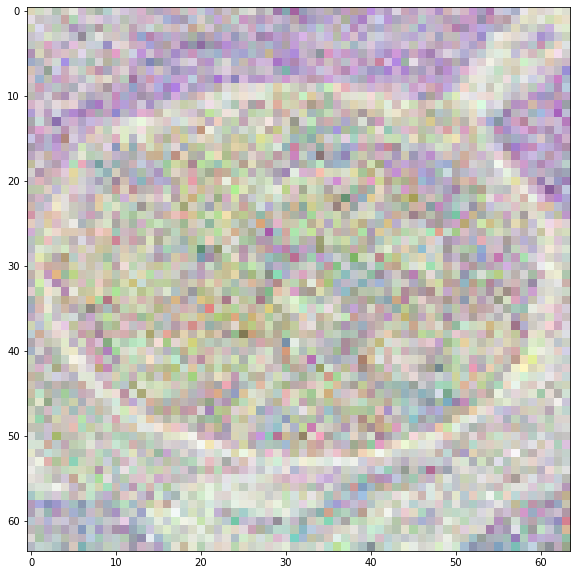

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(((latents - latents.min()) / (latents.max() - latents.min())).cpu()[0].permute(1,2,0))

In [ ]:
with torch.no_grad():
  latent_img = model.decode_latents(latents)

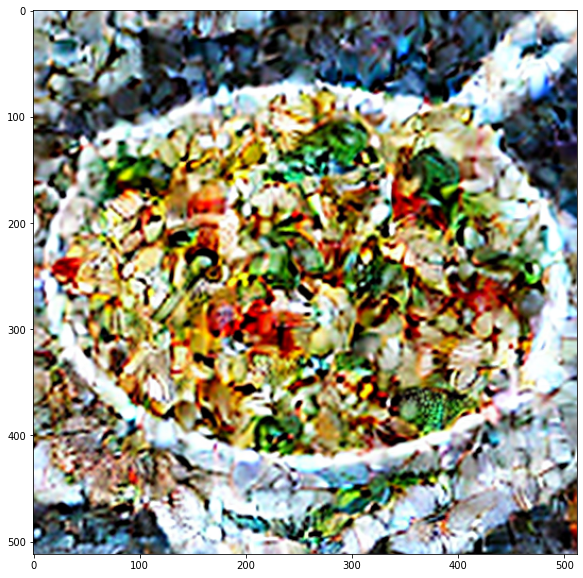

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(latent_img[0])

In [ ]:
latent_img.shape

(1, 512, 512, 3)

['Salad']


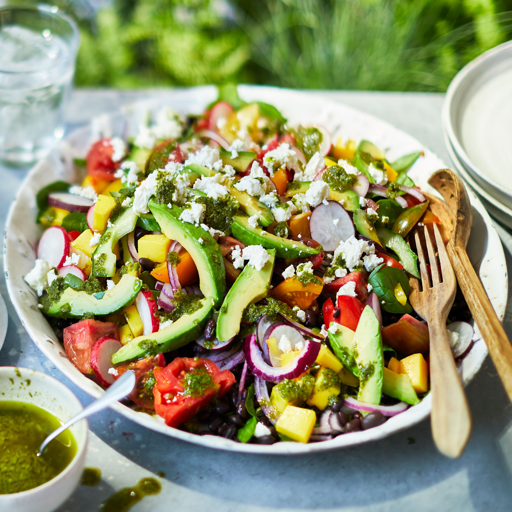

In [ ]:
# Objects to detect in the image separated by spaces
prompts1 = [
  "Salad"
]
print(prompts1)

# Image
url1 = "https://images.immediate.co.uk/production/volatile/sites/30/2014/05/Epic-summer-salad-hub-2646e6e.jpg"

response1 = requests.get(url1)
init_img1 = Image.open(BytesIO(response1.content)).convert("RGB")
# init_img = Image.open('img.png').convert("RGB")
init_img1 = init_img1.resize((512, 512))
init_img1

In [ ]:
prompt = prompts1
init_image = init_img1
strength = 0.3
num_inference_steps = 100
guidance_scale= 7.5
negative_prompt = None
num_images_per_prompt = 1
eta = 0.0
generator = None
output_type = "pil"
return_dict = True
callback = None
callback_steps = 1

with torch.no_grad():
    # 1. Check inputs
    model.check_inputs(prompt, strength, callback_steps)

    # 2. Define call parameters
    batch_size = 1 if isinstance(prompt, str) else len(prompt)
    device = model._execution_device
    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    do_classifier_free_guidance = guidance_scale > 1.0

    # 4. Preprocess image
    if isinstance(init_image, PIL.Image.Image):
        init_image = preprocess(init_image)

    # 5. set timesteps
    model.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = model.get_timesteps(num_inference_steps, strength, device)
    latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)

    # 6. Prepare latent variables
    latents1 = model.prepare_latents(
        init_image, latent_timestep, batch_size, num_images_per_prompt, text_embeddings.dtype, device, generator
    )

In [ ]:
latents1.shape

torch.Size([1, 4, 64, 64])

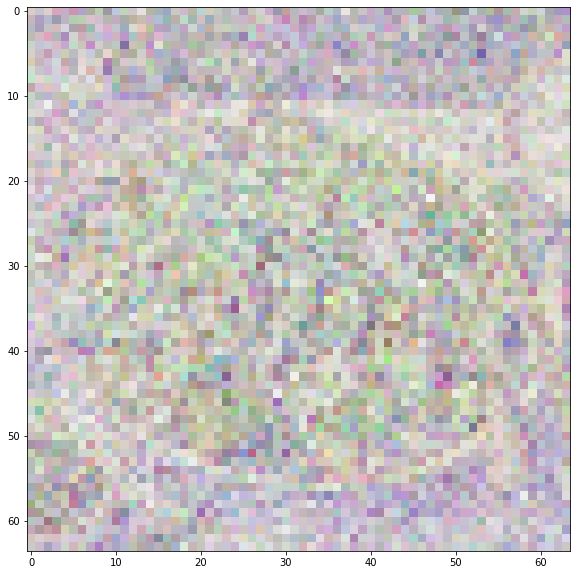

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(((latents1 - latents1.min()) / (latents1.max() - latents1.min())).cpu()[0].permute(1,2,0))

In [ ]:
with torch.no_grad():
  latent_img1 = model.decode_latents(latents1)

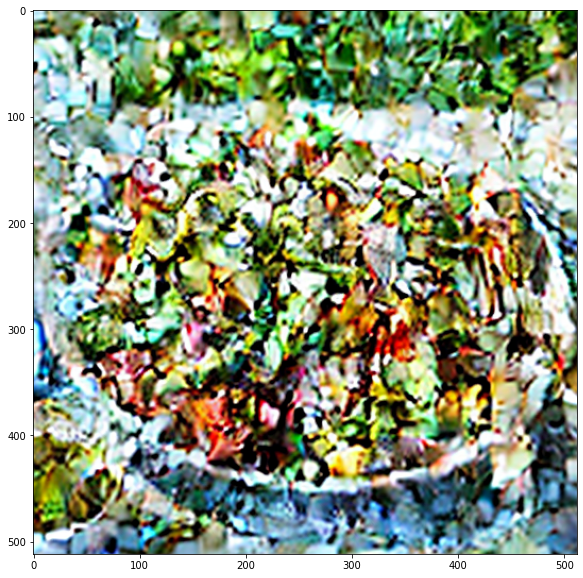

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(latent_img1[0])

In [ ]:
latent_img1.shape

(1, 512, 512, 3)

Merging Two Latent Representation
- Using Patch
- Using Partition

In [ ]:
# patch_height, patch_width = 20, 20
# intruder_patch = latents1[:, :, (latents1.shape[2]-patch_height)//2: (latents1.shape[2]+patch_height)//2, (latents1.shape[3]-patch_width)//2: (latents1.shape[3]+patch_width)//2]
# latents[:, :, (latents.shape[2]-patch_height)//2: (latents.shape[2]+patch_height)//2, (latents.shape[3]-patch_width)//2: (latents.shape[3]+patch_width)//2] = intruder_patch

In [ ]:
# Partition Merge
latents[:, :, :, (latents.shape[3])//2:] = latents1[:, :, :, (latents1.shape[3])//2:]

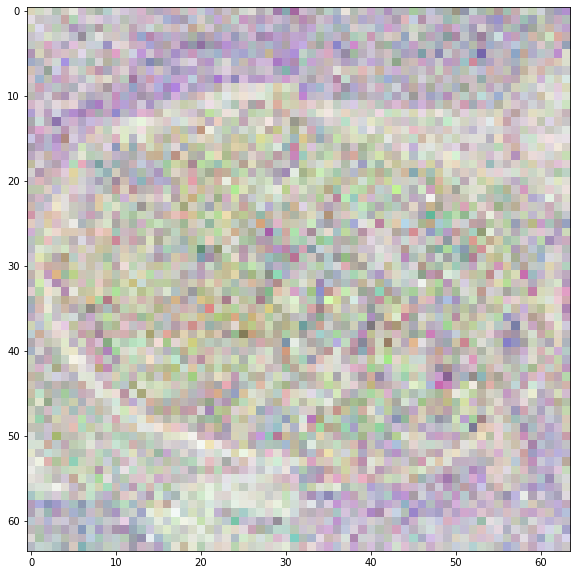

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(((latents - latents.min()) / (latents.max() - latents.min())).cpu()[0].permute(1,2,0))

In [ ]:
with torch.no_grad():
  latent_img = model.decode_latents(latents)

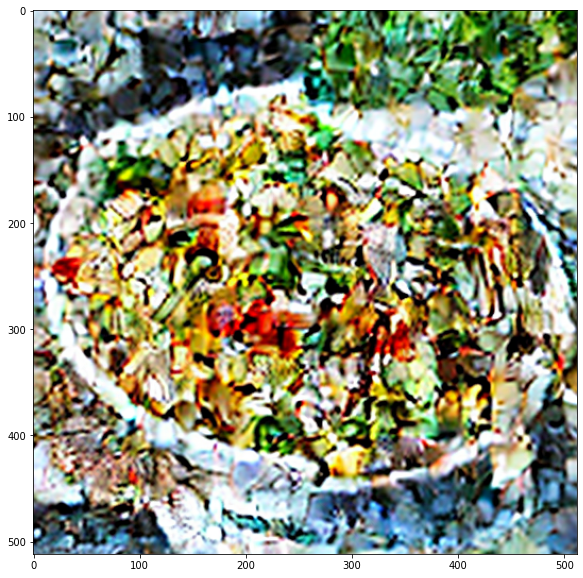

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(latent_img[0])

In [ ]:
prompt = ['salad']

  0%|          | 0/31 [00:00<?, ?it/s]

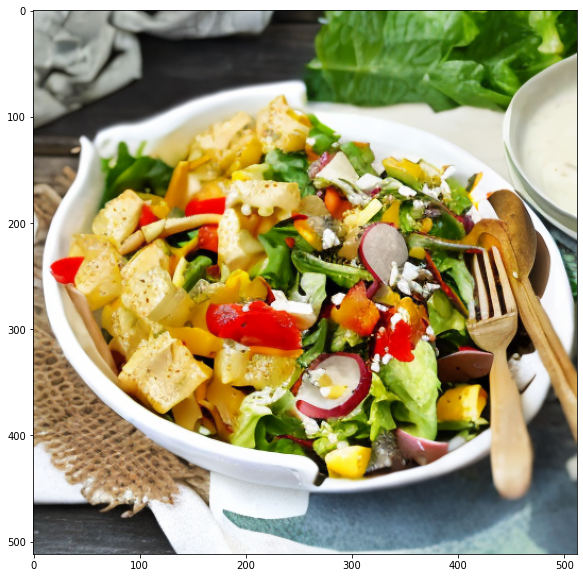

In [ ]:
with torch.no_grad():

    # 3. Encode input prompt
    text_embeddings = model._encode_prompt(
        prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )
    
    # 7. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
    extra_step_kwargs = model.prepare_extra_step_kwargs(generator, eta)

    # 8. Denoising loop
    for i, t in enumerate(model.progress_bar(timesteps)):
        # print latent
        # intermediate = model.decode_latents(latents)
        # plt.figure(figsize=(10,10))
        # plt.imshow(intermediate[0])
        # # plt.savefig(f'Steps/{i}.png')
        # plt.show()


        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = model.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = model.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = model.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

        # call the callback, if provided
        if callback is not None and i % callback_steps == 0:
            callback(i, t, latents)
            
    # print latent
    # intermediate = model.decode_latents(latents)
    # plt.figure(figsize=(10,10))
    # plt.imshow(intermediate[0])
    # # plt.savefig('Steps/a.png')
    # plt.show()

    # 9. Post-processing
    image = model.decode_latents(latents)

    # 10. Run safety checker
    image, has_nsfw_concept = model.run_safety_checker(image, device, text_embeddings.dtype)

    # Display Decoded Image
    plt.figure(figsize=(10,10))
    plt.imshow(image[0])
    # plt.savefig('Steps/b.png')
    plt.show()

    # 11. Convert to PIL
    if output_type == "pil":
        image = model.numpy_to_pil(image)

In [ ]:
prompt = ['pasta']

  0%|          | 0/31 [00:00<?, ?it/s]

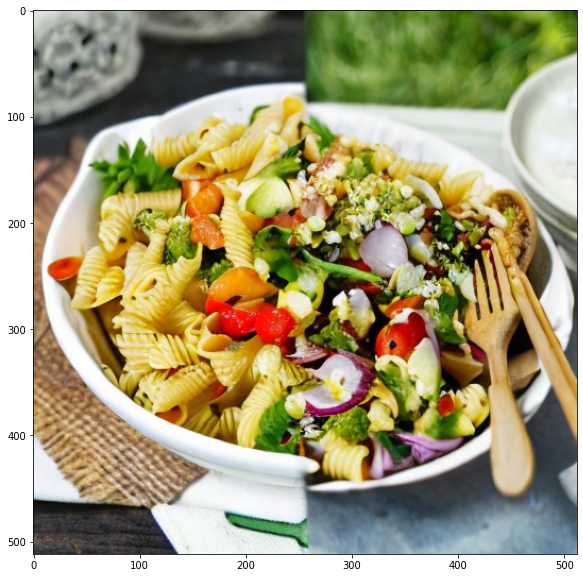

In [ ]:
with torch.no_grad():

    # 3. Encode input prompt
    text_embeddings = model._encode_prompt(
        prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )
    
    # 7. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
    extra_step_kwargs = model.prepare_extra_step_kwargs(generator, eta)

    # 8. Denoising loop
    for i, t in enumerate(model.progress_bar(timesteps)):
        # print latent
        # intermediate = model.decode_latents(latents)
        # plt.figure(figsize=(10,10))
        # plt.imshow(intermediate[0])
        # # plt.savefig(f'Steps/{i}.png')
        # plt.show()


        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = model.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = model.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = model.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

        # call the callback, if provided
        if callback is not None and i % callback_steps == 0:
            callback(i, t, latents)
            
    # print latent
    # intermediate = model.decode_latents(latents)
    # plt.figure(figsize=(10,10))
    # plt.imshow(intermediate[0])
    # # plt.savefig('Steps/a.png')
    # plt.show()

    # 9. Post-processing
    image = model.decode_latents(latents)

    # 10. Run safety checker
    image, has_nsfw_concept = model.run_safety_checker(image, device, text_embeddings.dtype)

    # Display Decoded Image
    plt.figure(figsize=(10,10))
    plt.imshow(image[0])
    # plt.savefig('Steps/b.png')
    plt.show()

    # 11. Convert to PIL
    if output_type == "pil":
        image = model.numpy_to_pil(image)

In [ ]:
import gc
# Frees up GPU to help reduce memory leak
def optimize_gpu():
  # Reset Already occupied Memory and Cache
  torch.cuda.reset_max_memory_allocated()
  torch.cuda.reset_max_memory_cached()
  torch.cuda.empty_cache()

  # Garbage Collection
  gc.collect()
optimize_gpu()